
#### This is forked from https://github.com/ghgr/HFT_Bitcoin, I have added some notes for myself better understanding.

In [1]:
from IPython.display import HTML
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
The raw code for this IPython notebook is by default hidden for easier reading.
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.''')

In [41]:
import pandas as pd
import json
import random
import datetime
import seaborn as sb
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['figure.figsize'] = (15.0, 5.0)
import numpy as np
from collections import Counter
import base64

In [3]:
plt.annotate?

In [42]:
# Basic Function to generate graphs, videos, images???

def annotate(x_point, y_point, x_text, y_text, text):
    plt.annotate(text, xy=(x_point, y_point), 
                 xytext=(x_text, y_text), 
                 arrowprops=dict(facecolor='black', shrink=0.05))
    
def video(fname, mimetype):
    from IPython.display import HTML
    #video_encoded = open(fname, "rb").read().decode("base64")
    with open(fname, 'rb') as image_file:
        video_encoded = base64.b64encode(image_file.read())

    video_tag = '<video loop autoplay alt="orderbook video" src="data:video/{0};base64,{1}" width=100%>'.format(mimetype, video_encoded)
    return HTML(data=video_tag)

def image(fname, width):
    from IPython.display import HTML    
    data = '<img src="%s" width=%d%%>' % (fname, width)
    return HTML(data=data)

# High Frequency Trading in Bitcoin Exchanges

Note: This article is the notebook corresponding to my post [High Frequency Trading in Bitcoin Exchanges](https://www.linkedin.com/pulse/high-frequency-trading-bitcoin-exchanges-eduardo-pena-vina) originally published on Linkedin on July 27, 2017.

## Introduction

In this post I analyze the **presence and activity of high frequency trading** in a Bitcoin exchange. Since to date this markets are *extremely unregulated*, such behaviour takes places with little to no constraint. I show how **over 99%** of orders placed are **not meant to be filled**, but instead to distort the perception of the market. In addition, I try to spot common HFT strategies, such as *Quote Spoofing*, *Layering* and *Momentum ignition*. Given the anonymous nature of these exchanges these last results are to some extent *subjective*.


## What is High Frequency Trading?

From Wikipedia [1], High-frequency trading (HFT) is a type of algorithmic trading characterized by high speeds, high turnover rates, and high order-to-trade ratios that leverages high-frequency financial data and electronic trading tools.

## Methodology

This analysis has been carried out with order data from the Websocket stream from **GDAX**, a US based digital asset exchange [2] owned by Coinbase. It is one of the largest markets (over **42 MM USD/day**) [3] and it exposes a high performance socket where all orders are broadcasted. In addition, it offers some interesting features for data analysis:

1. Orders are timestamped (as opposed to Bitfinex, for example)
2. It has millisecond granularity (again, as opposed to Bitfinex)
3. It says whether an order has been matched or cancelled -one could argue that disappearing orders far from the bid/ask spread must have been cancelled (and it's true), but for orders *inside* the spread, this information is necessary.


While data has been captured for several days (at the time of this post I'm still capturing data), for the following analysis only data from **July 21, 2017** has been taken. Mind you, there are still **over 2 Million datapoints**.


Since the GDAX feed does not explicitly keep information of the current best bid/ask, a little preprocessing is needed. The best bid is the *highest* price for currently open *BUY* orders, while the best ask is the *lowest* price for open *SELL* orders. Although this calculation is not complicated nor particularly slow, it's better to explicitly append the current best bid/ask as additional columns. No further preprocessing has been carried out.

## Related work

While writing this article, I came across a blog post from Philip Stubbings at *Parasec* [4], who made a **similar analysis in 2014**. While the amount of data differs by orders of magnitude, the findings are the same, especially concerning *flashing orders*. Quoting from his site:

> I collected order book event data from the Bitstamp exchange over a **4 month period**, between July and October (2014), resulting in a dataset of **~33 million individual events**; A minuscule dataset in comparison to the throughput on "conventional" exchanges, see (Nanex: High Frequency Quote Spam) for example. 

> While the event dataset consists of ~33 million events, these events can be broken down into individual orders and their types. In total, of the identifiable order types, **there were 14,619,019 individual "flashed orders"** (orders added and later deleted without being hit) **representing 93% of all order book activity**, 707,113 "resting orders" (orders added and not deleted unless hit) and 455,825 "marketable orders" (orders that crossed the book resulting in 1 or more reported trades). 

As we'll soon see in this report, I recorded **2,169,450** events in less than one day. That means, the number of events per unit of time is ** 8 times bigger than in 2014**. *Flash orders* are still a majority, **representing over 99% of all order book activity**.

## Analysis

### Data exploration

In [5]:
filename = 'data/2017_07_21_10_52_05.csv.gz'
data = pd.read_csv(filename,  parse_dates=['time'], index_col="time")
data['time'] = data.index

In [7]:
data.columns

Index(['client_oid', 'funds', 'maker_order_id', 'order_id', 'order_type',
       'price', 'product_id', 'reason', 'remaining_size', 'sequence', 'side',
       'size', 'taker_order_id', 'trade_id', 'type', 'bid', 'ask', 'time'],
      dtype='object')

In [10]:
data.head(10)

,client_oid,funds,maker_order_id,order_id,order_type,price,product_id,reason,remaining_size,sequence,side,size,taker_order_id,trade_id,type,bid,ask,time
time,,,,,,,,,,,,,,,,,,
2017-07-21 08:52:06.163,150051ad-336a-4429-a1f7-e8e6c07a30fb,NaN,NaN,6fdae78f-f00f-4dee-95f2-0ffb6ca2dfb4,limit,2715.35,BTC-USD,NaN,NaN,3649404788,buy,0.089439,NaN,NaN,received,2715.35,NaN,2017-07-21 08:52:06.163
2017-07-21 08:52:06.163,NaN,NaN,NaN,6fdae78f-f00f-4dee-95f2-0ffb6ca2dfb4,NaN,2715.35,BTC-USD,NaN,0.089439,3649404789,buy,NaN,NaN,NaN,open,2715.35,NaN,2017-07-21 08:52:06.163
2017-07-21 08:52:06.165,NaN,NaN,NaN,a7d073fb-c741-4f87-8a43-699462e597a4,NaN,2708.71,BTC-USD,canceled,0.200000,3649404790,buy,NaN,NaN,NaN,done,2715.35,NaN,2017-07-21 08:52:06.165
2017-07-21 08:52:06.167,NaN,NaN,NaN,5936f368-9b87-477e-9adc-83f14a525491,NaN,2708.66,BTC-USD,canceled,0.500000,3649404791,buy,NaN,NaN,NaN,done,2715.35,NaN,2017-07-21 08:52:06.167
2017-07-21 08:52:06.168,NaN,NaN,NaN,71dbb9bf-8a6c-4c0b-8ca2-259d16be43e1,NaN,2708.71,BTC-USD,canceled,0.200000,3649404792,buy,NaN,NaN,NaN,done,2715.35,NaN,2017-07-21 08:52:06.168
2017-07-21 08:52:06.168,NaN,NaN,NaN,12a0db8d-4ed0-432c-bee7-f32c0b2283b7,NaN,2708.71,BTC-USD,canceled,0.500000,3649404793,buy,NaN,NaN,NaN,done,2715.35,NaN,2017-07-21 08:52:06.168
2017-07-21 08:52:06.177,407e2e7a-217d-43d0-bd67-436e327c8980,NaN,NaN,295bcc10-1115-4628-bfc9-7df255ec6972,limit,2708.72,BTC-USD,NaN,NaN,3649404794,buy,0.500000,NaN,NaN,received,2715.35,NaN,2017-07-21 08:52:06.177
2017-07-21 08:52:06.177,NaN,NaN,NaN,295bcc10-1115-4628-bfc9-7df255ec6972,NaN,2708.72,BTC-USD,NaN,0.500000,3649404795,buy,NaN,NaN,NaN,open,2715.35,NaN,2017-07-21 08:52:06.177
2017-07-21 08:52:06.188,63aed4ee-da25-4a2f-9744-a6a4408391eb,NaN,NaN,437b2612-b918-4e60-8dc6-df4a1657d77e,limit,2708.72,BTC-USD,NaN,NaN,3649404796,buy,0.200000,NaN,NaN,received,2715.35,NaN,2017-07-21 08:52:06.188


First step, load data in memory (2,169,450 trades) corresponding to 723,880 different orders.

In [11]:
print "Loaded {:,} trades".format(data.shape[0])

SyntaxError: invalid syntax (<ipython-input-11-8afcc7ba9b53>, line 1)

In [12]:
print ("Loaded {:,} orders".format(data.order_id.nunique()))

Loaded 723,880 orders


The provided data feed looks like that:

There are multiple fields and many NaN (Not-a-Number) values. This happens because all sort of orders are mixed, and not every field is relevant to every order. (For details the reader is kindly pointed to the official documentation [7]).
We can focus on the most commonly relevant parameters:

In [13]:
keys = ['price','remaining_size','side','reason','type','order_id']

In [14]:
data[keys].head()

,price,remaining_size,side,reason,type,order_id
time,,,,,,
2017-07-21 08:52:06.163,2715.35,NaN,buy,NaN,received,6fdae78f-f00f-4dee-95f2-0ffb6ca2dfb4
2017-07-21 08:52:06.163,2715.35,0.089439,buy,NaN,open,6fdae78f-f00f-4dee-95f2-0ffb6ca2dfb4
2017-07-21 08:52:06.165,2708.71,0.200000,buy,canceled,done,a7d073fb-c741-4f87-8a43-699462e597a4
2017-07-21 08:52:06.167,2708.66,0.500000,buy,canceled,done,5936f368-9b87-477e-9adc-83f14a525491
2017-07-21 08:52:06.168,2708.71,0.200000,buy,canceled,done,71dbb9bf-8a6c-4c0b-8ca2-259d16be43e1


Now the data is clearer. Each order is defined by its **arrival time** (at the server), its **price**, **amount**, **side** (*buy* or *sell*), **status** and **unique id**. We see that for the first 5 orders, 3 of the are cancellations! (more about that soon).

#### Granularity(n. 间隔尺寸、粒度) of data

Let's take the time different between arriving orders, and plot as histogram

In [15]:
dt = data.time.diff().iloc[1:].dt
dt = dt.seconds.astype(np.float) + dt.microseconds * 1e-6  
dt*=1000

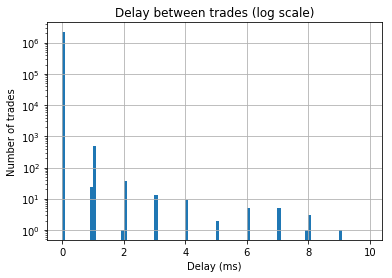

In [16]:
dt.sort_values().diff().hist(bins = np.arange(0,10,0.1)); 
plt.yscale('log')
plt.xlabel("Delay (ms)")
plt.ylabel("Number of trades")
plt.title("Delay between trades (log scale)")
plt.show()

We see that a large amount of orders take place simultaneously, and that the smallest *non zero* value of time delay is 1 **ms**. We can directly confirm it with code:

In [21]:
print ("Minimum non zero number of milliseconds: ", dt[dt>0].min())

Minimum non zero number of milliseconds:  1.0


#### Analysis of orders by id

In [22]:
data[data.order_id=='9144b925-ecb6-40fa-880b-2e9f83039812'][keys+['order_type']]

,price,remaining_size,side,reason,type,order_id,order_type
time,,,,,,,
2017-07-21 08:52:46.605,NaN,NaN,buy,NaN,received,9144b925-ecb6-40fa-880b-2e9f83039812,market
2017-07-21 08:52:46.605,NaN,0.0,buy,filled,done,9144b925-ecb6-40fa-880b-2e9f83039812,NaN


An interesting observation that will be useful later is that each order_id appear at most three times (99.01%). That means, the order arrives, the order waits ("open") and the order is matched or cancelled. 

In [24]:
for order, freq in Counter(data.groupby('order_id').size()).most_common():
    print (order, freq)

3 716746
2 5048
1 2086


#### Analysis of orders by outcome

An incoming order has two possible outcomes. Either it is filled (matched with an existing or incoming order) or is is cancelled. During this observation 7,053 orders were filled, while a majority of 714,648 where *Cancelled*. That is a 99.02% of incoming orders were ultimately cancelled!

In [25]:
data.groupby('reason').size()

reason
canceled    714648
filled        7053
dtype: int64

#### Grouping orders

A different exchange, Bitfinex, has been previously analyzed (not shown here for the sake of conciseness). Its data-feed had some major drawbacks that ultimately made me drop it and work with GDAX. Nevertheless, its so called "Raw Book Order" feed, showed interesting information. In that exchange traders don't seem to Send/Cancel many orders, but rather Send/Update/Update/Update/.../Update/Cancel. I don't fully understand why, but I guess it could be to bypass API Limits and to optimize execution of orders (by keeping the place in the order book at a given price). 

In any case, I saw that quickly arriving and cancelling orders (flashing orders) at a given price and similar amount are caused by the same individual. Knowing that, let's find orders at a given price and amount. For example, 0.5BTC@$2707.81

In [26]:
w=data[(data.price==2707.81) & (data.remaining_size==0.5)]
w[['price','remaining_size','side','reason','order_id']].tail()

,price,remaining_size,side,reason,order_id
time,,,,,
2017-07-21 08:58:07.488,2707.81,0.5,buy,canceled,04211005-4140-44c5-98d6-65fcec8eb9e5
2017-07-21 08:58:57.500,2707.81,0.5,buy,NaN,17eb23e8-b967-4413-89ed-31ab57f2fc3c
2017-07-21 08:58:57.741,2707.81,0.5,buy,canceled,17eb23e8-b967-4413-89ed-31ab57f2fc3c
2017-07-21 10:47:39.363,2707.81,0.5,buy,NaN,44c11417-a3a0-4d3c-9672-5b35d59e97e4
2017-07-21 10:47:39.882,2707.81,0.5,buy,canceled,44c11417-a3a0-4d3c-9672-5b35d59e97e4


Let's focus on order 04211005-4140-44c5-98d6-65fcec8eb9e5

In [27]:
data[data.order_id=="04211005-4140-44c5-98d6-65fcec8eb9e5"][['price','remaining_size','side','reason','order_id','type', 'bid','ask']]

,price,remaining_size,side,reason,order_id,type,bid,ask
time,,,,,,,,
2017-07-21 08:58:07.193,2707.81,NaN,buy,NaN,04211005-4140-44c5-98d6-65fcec8eb9e5,received,2713.2,2714.51
2017-07-21 08:58:07.193,2707.81,0.5,buy,NaN,04211005-4140-44c5-98d6-65fcec8eb9e5,open,2713.2,2714.51
2017-07-21 08:58:07.488,2707.81,0.5,buy,canceled,04211005-4140-44c5-98d6-65fcec8eb9e5,done,2713.2,2714.51


This BUY order was placed **and cancelled 295 ms later** at a level of $2707.81 (when the best ASK price was 2714.51). It seems obvious that this order had no expectation of being filled. 
Let's see if orders are flashed at higher or lower frequencies than 295 ms.

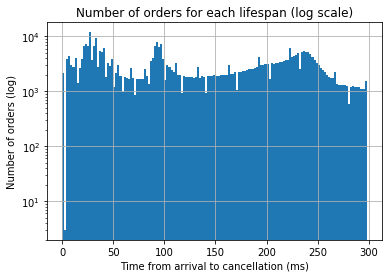

In [28]:
canceled_idx = data.order_id[data.reason=="canceled"]
d = data[data.order_id.isin(canceled_idx)]
g = d.groupby("order_id")
dt = g.time.last() - g.time.first()
duration = dt.dt.seconds.astype(np.float) + dt.dt.microseconds*1e-6  
duration*=1000
duration.hist(bins = np.arange(0,300,2));
plt.yscale('log')
plt.title("Number of orders for each lifespan (log scale)")
plt.ylabel("Number of orders (log)")
plt.xlabel("Time from arrival to cancellation (ms)")
plt.show()

Indeed, there are orders flashing at <5 milliseconds! Let's see some of the fastest flashing orders:

In [29]:
duration[duration>1].sort_values().head()

order_id
7f043088-f9ad-46f6-bfae-e577db3f7363    3.0
7162ca12-94eb-4b50-9249-3562152add62    3.0
42af6ed7-aeb1-4cb7-b787-e19c4a54f418    3.0
bf51ca32-5b6d-4a7d-ac78-433a1dd1f27e    4.0
47a435dc-3627-4d07-b702-cb27e60ec329    4.0
Name: time, dtype: float64

For example, let's take order_id 7f043088-f9ad-46f6-bfae-e577db3f7363

In [30]:
data[data.order_id=="7f043088-f9ad-46f6-bfae-e577db3f7363"][keys+['bid','ask']]

,price,remaining_size,side,reason,type,order_id,bid,ask
time,,,,,,,,
2017-07-21 12:45:45.516,2769.99,NaN,sell,NaN,received,7f043088-f9ad-46f6-bfae-e577db3f7363,2767.87,2767.96
2017-07-21 12:45:45.516,2769.99,0.5,sell,NaN,open,7f043088-f9ad-46f6-bfae-e577db3f7363,2767.87,2767.96
2017-07-21 12:45:45.519,2769.99,0.5,sell,canceled,done,7f043088-f9ad-46f6-bfae-e577db3f7363,2767.87,2767.96


Three milliseconds is an extremely short amount of time considering the GDAX Rate Limits:

> ### Rate Limits
> 1. We throttle public endpoints by IP: 3 requests per second, up to 6 requests per second in bursts.
> 2. We throttle private endpoints by user ID: 5 requests per second, up to 10 requests per second in bursts.
> 3. The FIX API throttles each command type (eg.: NewOrderSingle, OrderCancelRequest) to **30 commands per second**.

What's **Really interesting** is that these patterns seem to exceed the API Limits (the highest, at 30 command per seconds, means 1 order each 33 ms).

So we can confidently say that **there are bots manipulating the order books**. The next question is, how many? and are they controlled by the same person? Let's find out...

#### Bots trading

In [31]:
def plotCancelBehaviourForPriceAndSize(price, size, lim=-1):

    plt.figure(figsize=(15,5))
    #q = data[data.order_id==most_prolific_bots.index[0]]

    q = data[((data['size']==size) | (data['remaining_size']==size)) & (data['price']==price)].head(lim)
    t=q.time.diff().median()
    median_tick_s = t.seconds+t.microseconds*1e-6;
    
    order_type = q.side.iloc[0]
    
    d = data.loc[q.index[0]:q.index[-1]]
    
    d.bid.plot(label="bid price"  )
    d.ask.plot(label="ask price")
    q[q.reason!="canceled"].price.plot(label="%s %.2f BTC @ %.2f" % (order_type, size, price), style='o');
    ylim0 = min(d.bid.min(), q.price.min())
    ylim1 = max(d.ask.max(), q.price.max())
    plt.vlines(q.index[q.reason=="canceled"], ylim0, ylim1, alpha = 0.2);
    plt.xlabel("Time")
    plt.ylabel("Price (USD)")
    plt.title("Cancelled orders along time for %.2f BTC @ $%.2f. Median tick: %.1f milliseconds" % (size, price,median_tick_s*1000))
    plt.legend(loc='best', frameon=True)
    
    plt.ylim(d.bid.min(), d.ask.max())
    plt.show()

Let's see the cancel behavior for different price levels and amounts. Red points are SELL orders (not always visible), vertical grey lines are cancellations and the blue and green lines are bid and ask price, respectively.

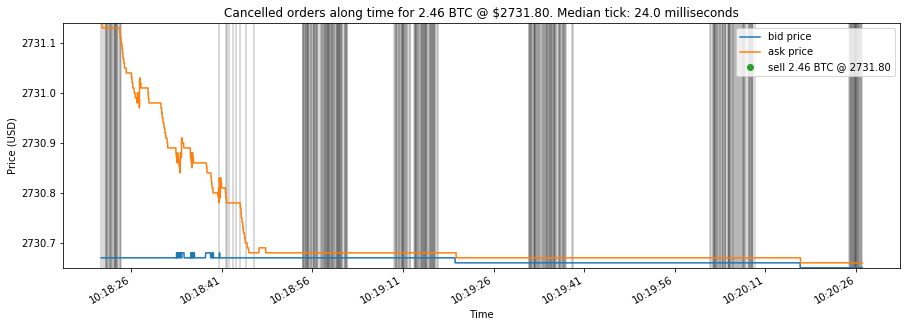

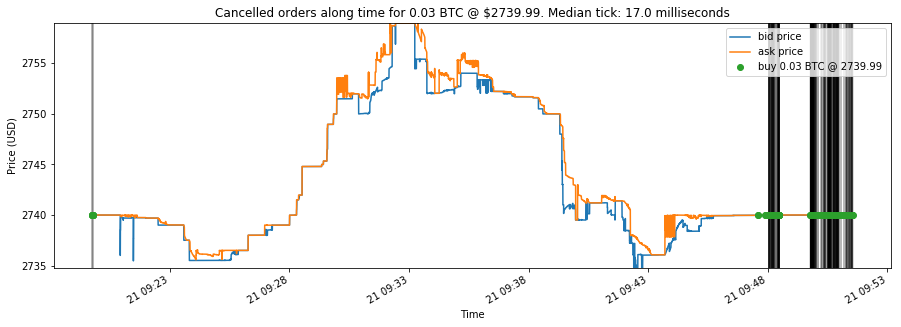

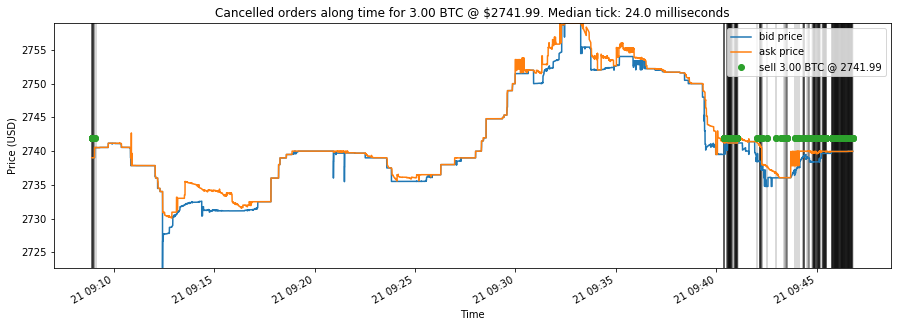

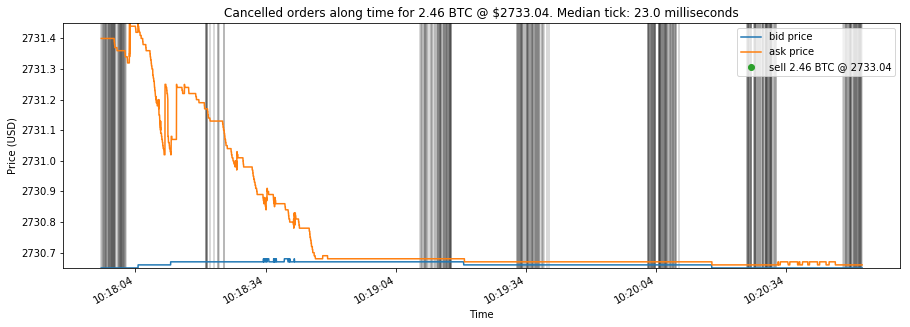

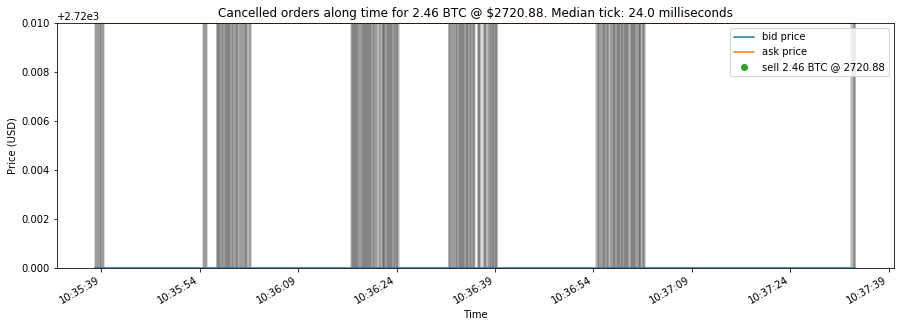

In [32]:
g = data.groupby(['price','size'])
for (price, size), i  in g.size().sort_values(ascending=False).head(5).iteritems():
    plotCancelBehaviourForPriceAndSize(price,size, lim=1000)

There is certainly a cadence of placing and cancelling orders.

## HTF Strategies

The Bocconi Students Investment Club (BSIC) [5] describes some strategies which the HFT traders use to distort the perception of the market. For this post I'll focus on Spoofing, Layering and Momentum Ignition.

### Spoofing & Layering

Quoting from BSIC [5]:

> Spoofing is a strategy whereby one places limit orders, and removes them before they are executed. By spoofing limit orders, perpetrators hope to distort other trader’s perceptions of market demand and supply. As an example, a large bid limit order could be placed with the intention of being canceled before it is executed. The spoofer would then seek to benefit from prices rising as the result of false optimism others would see in the market structure.

### Detection

There is evidence of high frequency spoofing on July 21, 2017 between 09:45:52 and 09:45:56. Let's take a look at the order book. Red points are SELL orders (3 BTC @ $2741.99), vertical grey lines are cancellations and the blue and green lines are bid and ask price, respectively.

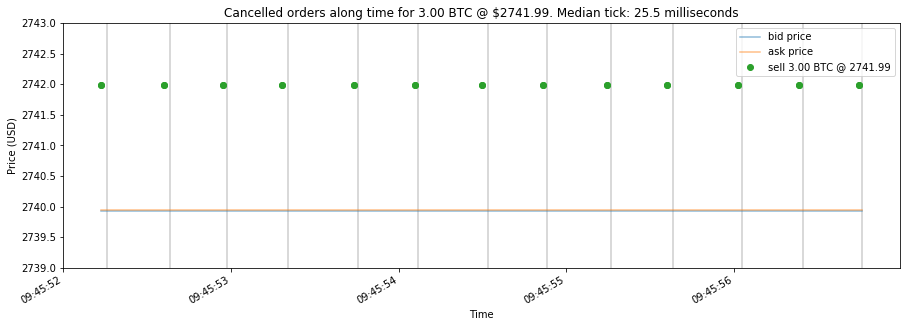

In [37]:
size = 3.00
price = 2741.99
plt.figure(figsize=(15,5))

q = data[((data['size']==size) | (data['remaining_size']==size)) & (data['price']==price)].head(1000)
q = q.loc['2017-7-21 9:45:52.000': '2017-7-21 9:45:56.000' ]
t=q.time.diff().median()
median_tick_s = t.seconds+t.microseconds*1e-6;
order_type = q.side.iloc[0]
d = data.loc[q.index[0]:q.index[-1]]
d.bid.plot(label="bid price" ,alpha = 0.5 )
d.ask.plot(label="ask price",alpha = 0.5)
q[q.reason!="canceled"].price.plot(label="%s %.2f BTC @ %.2f" % (order_type, size, price), style='o');
ylim0 = 2739
ylim1 = 2743
plt.vlines(q.index[q.reason=="canceled"], ylim0, ylim1, alpha = 0.2);
plt.xlabel("Time")
plt.ylabel("Price (USD)")
plt.title("Cancelled orders along time for %.2f BTC @ $%.2f. Median tick: %.1f milliseconds" % (size, price,median_tick_s*1000))
plt.legend(loc='best', frameon=True)

plt.ylim(ylim0, ylim1)
plt.show()

The orders are cancelled around 25 ms after they arrive! They are flashed with a frequency of around 3 Hz. The following animation shows the order book in more or less real time. Notice how a SELL order flashes at level 2741.99 with amount 3 BTC.

In [44]:
def plotOrderBookAtTime(t,xmin, xmax, ymax, fname=False, arrowAtPrice=False):
    data_past = data[data.index<=t]
    q=data_past.groupby('order_id').type.last()=="open"
    q = data_past[data_past.order_id.isin(q[q].index)]
    q = q[q.type=="received"]

    ask = q[q.side=="sell"].groupby('price')['size'].sum().sort_index(ascending=True)
    bid = q[q.side=="buy"].groupby('price')['size'].sum().sort_index(ascending=False)

    plt.bar(bid.index, bid, width = 0.01, color='g')
    plt.bar(ask.index, ask, width = 0.01, color='r')
    #xmin, xmax = np.percentile(bid.index,80), np.percentile(ask.index,20)
    #ymin, ymax = 0, max(bid[bid.index>xmin].max(), ask[ask.index<xmax].max())
    plt.xlim(xmin, xmax)
    plt.ylim(0, ymax)    
    plt.title("Order book at time: "+str(t))
    plt.xlabel("Price (USD)")
    plt.ylabel("Depth (BTC)")
    if arrowAtPrice:
        plt.xticks(list(plt.xticks()[0]) + [arrowAtPrice])
        plt.annotate('$%.2f' % (arrowAtPrice), xy=(arrowAtPrice, ymax-4), xytext=(arrowAtPrice, ymax-1),arrowprops=dict(facecolor='black', shrink=0.05))
    if fname:
        plt.savefig(fname)
        plt.close()
    else:
        plt.show()
    

if False:
    dates = data.loc['2017-7-21 9:45:52.000'].index
    dates = dates.append(data.loc['2017-7-21 9:45:53.000'].index)
    dates = dates.append(data.loc['2017-7-21 9:45:54.000'].index)
    dates = dates.append(data.loc['2017-7-21 9:45:55.000'].index)
    dates = dates.append(data.loc['2017-7-21 9:45:56.000'].index)    
    ts = [t for t in dates]
    for i,t in enumerate(ts):
        plotOrderBookAtTime(t,2730, 2750, 10, fname = "img/pic_%05d.png" % (i), arrowAtPrice=2741.99)
        print ("Done %d/%d" % (i, len(ts)))        


video("videos/animation1.mp4","mp4")

One interesting thing is that neither the bid or ask price moves.

Also from [5]:
> More controversial has been the act of layering which carries many similarities to outright spoofing, but differs in that orders are placed evenly across prices with the goal of reserving an early execution priority at each given price level. If the person has no trade to execute at that price point the orders are simply removed. Despite being more benign in nature, the act of layering also distorts market demand and supply perception.

It seems to be evidence of layering. Let's take a closer look at the minute between July 21, 2017 between 09:41:00 and 9:42:00. Orders seem to push the ASK level downwards, eventually decreasing the BID price. Next, BUY orders are placed at this lowered level, to be sold when the BID price recovers.

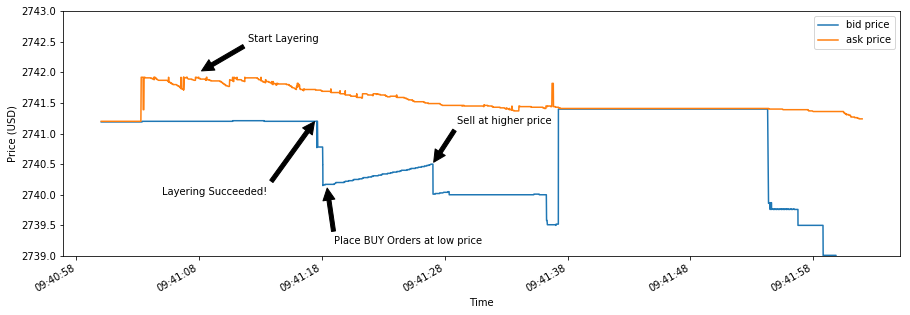

In [45]:
q = data.loc['2017-7-21 9:41:00.000': '2017-7-21 9:42:01.000' ]

ymin, ymax = 2739, 2743

q.bid.plot(label="bid price")
q.ask.plot(label="ask price")

plt.xlabel("Time")
plt.ylabel("Price (USD)")
plt.legend(loc='best', frameon=True)

plt.ylim(ymin, ymax)

plt.annotate('Start Layering', xy=('2017-7-21 9:41:08.000', 2742), xytext=('2017-7-21 9:41:12.000', 2742.5),arrowprops=dict(facecolor='black', shrink=0.05))
plt.annotate('Layering Succeeded!', xy=('2017-7-21 9:41:17.600', 2741.25), xytext=('2017-7-21 9:41:05.000', 2740),arrowprops=dict(facecolor='black', shrink=0.05))

plt.annotate('Place BUY Orders at low price', xy=('2017-7-21 9:41:18.400', 2740.15), xytext=('2017-7-21 9:41:19.000', 2739.2),arrowprops=dict(facecolor='black', shrink=0.05))
plt.annotate('Sell at higher price', xy=('2017-7-21 9:41:27.000', 2740.5), xytext=('2017-7-21 9:41:29.000', 2741.15),arrowprops=dict(facecolor='black', shrink=0.05))

plt.show()

### Momentum ignition

Still quoting [5]

> Momentum ignition is a strategy in which a trader aims to cause a sharp movement in the price of a stock by using a series of trades, which indicate patterns for high frequency traders, with the motive of attracting other algorithm traders to also trade that stock. The instigator of the whole process knows that after the somewhat “artificially created” rapid price movement, the price reverts to normal and thus the trader profits by taking a position early on and eventually trading out before it fizzles out.

>To detect momentum ignition, it is important to focus on the following three main characteristics as shown in the chart below:

>1.          Stable prices and a spike in volume
>2.          A large price movement compared to the intraday volatility
>3.          Reversion to the starting price under a lower volume

The following picture from zerohedge and Credit Suisse AES Analysis illustrates this behavior.

In [46]:
image("img/momentum.png", 70)

This behaviour takes place on July 21, 2017 between 12:00:20 and 12:50:01

/Users/Hansen/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: FutureWarning: pd.TimeGrouper is deprecated and will be removed; Please use pd.Grouper(freq=...)
  
/Users/Hansen/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: pd.TimeGrouper is deprecated and will be removed; Please use pd.Grouper(freq=...)
  if __name__ == '__main__':


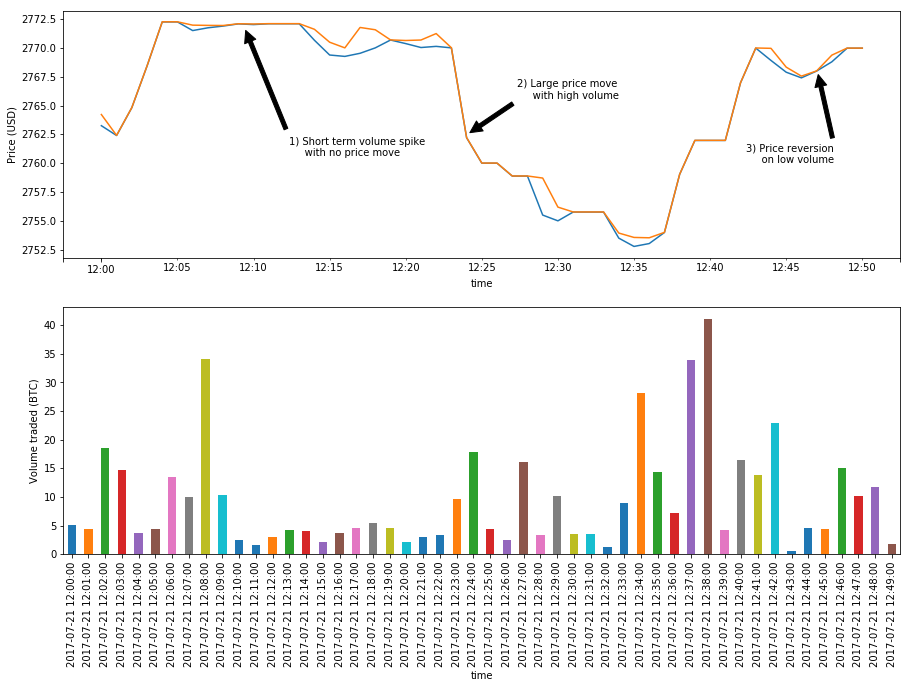

In [47]:
plt.figure(figsize=(15,10))
plt.subplot(211)
t0 = '2017-7-21 12:00:20.000'
t1 = '2017-7-21 12:50:01.000' 

q = data.loc[t0:t1].groupby(pd.TimeGrouper(freq='60S'))
bids = q.bid.last()
asks = q.ask.last()
vol = data[data.type=='match'].loc[t0:t1].groupby(pd.TimeGrouper(freq='60S'))['size'].sum()

bids.plot()
asks.plot()
plt.ylabel("Price (USD)")
annotate('2017-7-21 12:09:20.000', 2772.0, '2017-7-21 12:12:20.000', 2760.6, "1) Short term volume spike\n     with no price move")
annotate('2017-7-21 12:24:03.000', 2762.5, '2017-7-21 12:27:20.000', 2765.6, "2) Large price move\n     with high volume")
annotate('2017-7-21 12:47:03.000', 2768.0, '2017-7-21 12:42:20.000', 2760.0, "3) Price reversion\n     on low volume")


plt.subplot(212)
vol.plot(kind='bar')
plt.ylabel("Volume traded (BTC)")

plt.show()

Taking a look at the timeframe between July 21, 2007 between 08:53:28 and 08:53:43 there seems to be a mix between momentum ignition and layering (see previous section). Note the spike in volume at 08:53:31.

/Users/Hansen/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:26: FutureWarning: pd.TimeGrouper is deprecated and will be removed; Please use pd.Grouper(freq=...)


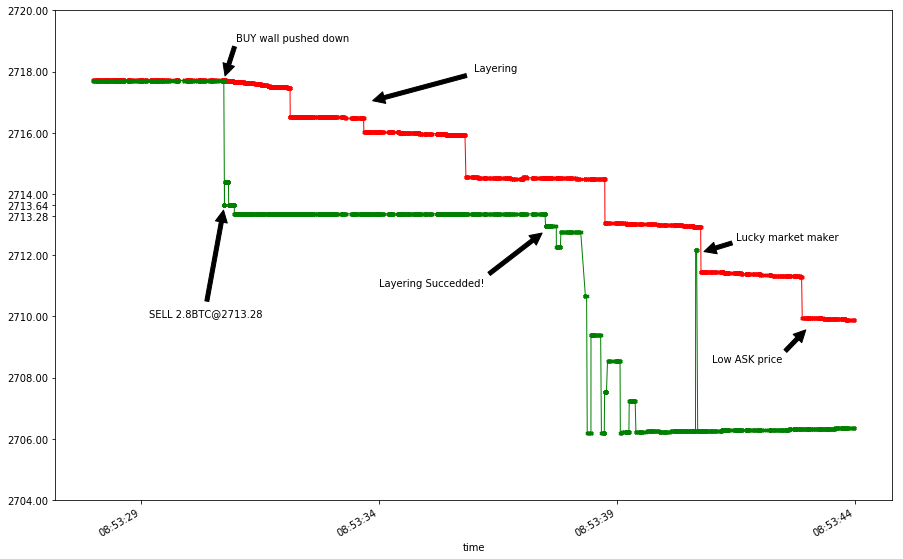

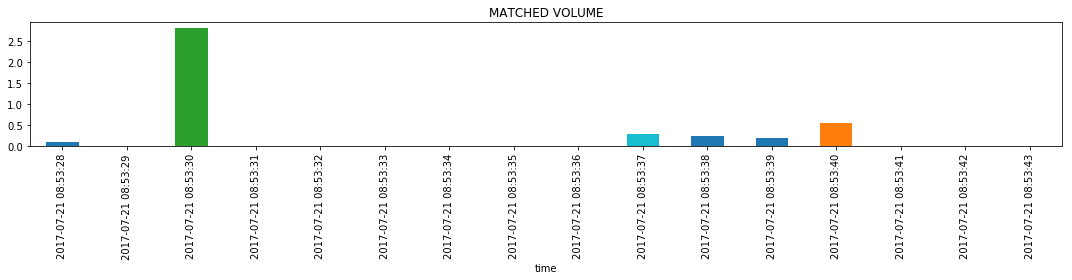

In [48]:
plt.figure(figsize=(15,10))
    
t0 = '2017-7-21 8:53:28.000'
t1 = '2017-7-21 8:53:43.000' 

q = data.loc[t0:t1]
bids = q.bid
asks = q.ask
#w = data.loc[t0:t1].groupby([pd.TimeGrouper(freq='5S'),'side'])

asks.plot(linestyle='-', marker='X', ms=3, c='r', linewidth=1)
bids.plot(linestyle='-', marker='X', ms=3, c='g', linewidth=1)


plt.yticks(list(plt.yticks()[0]) + [2713.64, 2713.28 ])

annotate('2017-07-21 08:53:30.763',2717.80, '2017-07-21 08:53:31.000',2719,'BUY wall pushed down')
annotate('2017-07-21 08:53:30.763',2713.64, '2017-07-21 08:53:29.173',2710,'SELL 2.8BTC@2713.28')
annotate('2017-07-21 08:53:33.763',2717.00, '2017-07-21 08:53:36.000',2718,'Layering')
annotate('2017-07-21 08:53:37.500',2712.80, '2017-07-21 08:53:34.000',2711,'Layering Succedded!')
annotate('2017-07-21 08:53:40.800',2712.10, '2017-07-21 08:53:41.500',2712.5,'Lucky market maker')
annotate('2017-07-21 08:53:43.000',2709.60, '2017-07-21 08:53:41.000',2708.5,'Low ASK price')


plt.figure(figsize=(15,4))
vol = data[data.type=='match'].loc[t0:t1].groupby(pd.TimeGrouper(freq='1S'))['size'].sum()
vol.plot(kind='bar')
plt.title("MATCHED VOLUME")
plt.tight_layout()

plt.show()

If we look 5 minutes into the future, until 08:58:00, we see that the price recovers to previous levels.

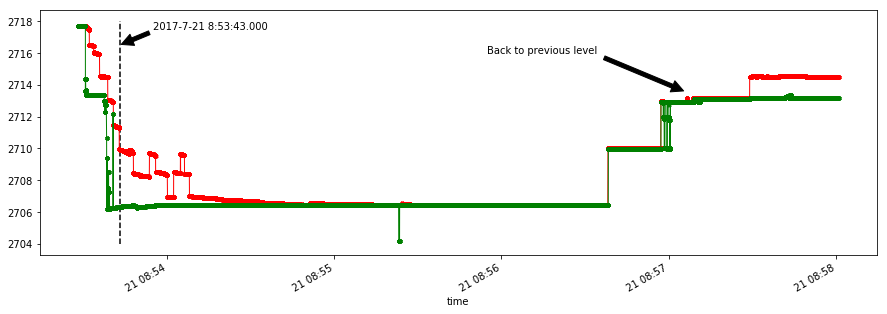

In [49]:
#plt.figure(figsize=(15,10))
    
t0 = '2017-7-21 8:53:28.000'
tmp = '2017-7-21 8:53:43.000' 
t1 = '2017-7-21 8:58:00.000' 

q = data.loc[t0:t1]
bids = q.bid
asks = q.ask
#w = data.loc[t0:t1].groupby([pd.TimeGrouper(freq='5S'),'side'])

asks.plot(linestyle='-', marker='X', ms=3, c='r', linewidth=1)
bids.plot(linestyle='-', marker='X', ms=3, c='g', linewidth=1)
plt.vlines(tmp,2704,2718, linestyles='--')
annotate(tmp,2716.5,'2017-7-21 8:53:55.000', 2717.5, tmp)
annotate('2017-7-21 8:57:7.000',2713.5,'2017-7-21 8:55:55.000', 2716, "Back to previous level")


plt.show()

## Conclusion

According to an interview carried out by The Atlantic [6] to Michael Kearns of the University of Pennsylvania and Andrew Lo at MIT, this behaviour also happens in traditional trading, and its causes are still matter of dispute. Relevant extract:
> [...] why would a firm engage in this behavior? Lo and Kearns offered a few theories of their own about what could be happening.

> To be honest, we can't come up with a good reason," Kearns said. What's particularly difficult to explain is how diverse and prevalent the patterns are. If algorithmic traders are simply testing new bots out -- which isn't a bad explanation -- it doesn't seem plausible that they'd do it so often. Alternatively, one could imagine the patterns are generated by some set of systemic information processing mistakes, but then it might be difficult to explain the variety of the patterns. 

> "It's possible that the observed patterns are not malicious, in error, or for testing, but for information-gathering," Kearns observed. "One could easily imagine a HFT shop wanting to regularly examine (e.g.) the latency they experienced from the different exchanges under different conditions, including conditions involving high order volume, rapid changes in prices and volumes, etc. And one might want such information not just when getting started, but on a regular basis, since latency and other exchange properties might well be expected to change over time, exhibit seasonality of various kind, etc. The super-HFT groups might even make co-location decisions based on such benchmarks." 

## References
[1]https://en.wikipedia.org/wiki/Bitfinex

[2] https://www.gdax.com/

[3] Source: https://coinmarketcap.com

[4] http://parasec.net/blog/order-book-visualisation/

[5]  http://www.bsic.it/marketmanipulation/

[6] https://www.theatlantic.com/technology/archive/2010/08/explaining-bizarre-robot-stock-trader-behavior/61028/

[7] https://docs.gdax.com/